In [2]:
import numpy as np
import tensorflow as tf
from glob import glob
from typing import List,Dict
from fnmatch import fnmatch
import matplotlib.pyplot as plt
import re
import os
print(tf.__version__)

2.4.1


In [ ]:
#root_path = r'D:\sd_dynObj'
file_pattern = '*_grid.npz'
source_path = r'D:\npz_files'

tfrec_tgt_path = r'D:\tf_records'
_MAX_LENGTH =25

# function to get files of same pattern
def get_all_bag_paths(root:str,pattern:str)->List[str]:
    list_file_paths=[]
    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern):
                list_file_paths.append((os.path.join(path, name)))

    return sorted(list_file_paths)

In [ ]:
all_grid_paths = get_all_bag_paths(source_path,pattern=file_pattern)
all_init_paths = get_all_bag_paths(source_path,pattern="*_init_path.npz")
all_opt_paths = get_all_bag_paths(source_path,pattern="*_opt_path.npz")
all_lr_bnd_paths = get_all_bag_paths(source_path,pattern="*_lr_bnd.npz")
all_odo_paths = get_all_bag_paths(source_path,pattern="*_odo.npz")

In [ ]:
#all_odo_paths

In [ ]:
print(len(all_grid_paths),len(all_init_paths),len(all_opt_paths),len(all_lr_bnd_paths),len(all_odo_paths))


In [ ]:
assert len(all_grid_paths)==len(all_init_paths)==len(all_opt_paths)==len(all_lr_bnd_paths)==len(all_odo_paths)

In [ ]:
def load_npz_data(file_path:str,array_name:str):
    return np.load(file_path)[array_name]

def get_names(path:str)->Dict[str,str]:
    list_split_path=path.split(os.sep)
    scene_name = list_split_path[-3]
    folder_name = list_split_path[-2]
    file_name = list_split_path[-1]
    file_prefix = re.split("_nos",file_name)[0]

    return scene_name,folder_name,file_name,file_prefix

print(type(np.int8))

In [ ]:
file_idx = 0


# Grid map== grid origin(samples==x==y)== grid resolution
in_grid_map = load_npz_data((all_grid_paths[file_idx]),"grid_data")
in_grid_map = (in_grid_map/127).astype(np.int8)

in_grid_org_res = load_npz_data((all_grid_paths[file_idx]),"grid_org_res")
in_grid_org_res = in_grid_org_res.astype(np.float32)

#Load paths(initial and optimal) and boundaries(left and right)
in_init_path = load_npz_data((all_init_paths[file_idx]),"init_path")
in_init_path = in_init_path.astype(np.float32)

out_opt_path = load_npz_data((all_opt_paths[file_idx]),"opt_path")
out_opt_path = out_opt_path.astype(np.float32)

in_left_bnd = load_npz_data((all_lr_bnd_paths[file_idx]),"left_bnd")
in_left_bnd = in_left_bnd.astype(np.float32)
in_right_bnd = load_npz_data((all_lr_bnd_paths[file_idx]),"right_bnd")
in_right_bnd = in_right_bnd.astype(np.float32)

#Car odometry
in_car_odo = load_npz_data((all_odo_paths[file_idx]),"odo_data")
in_car_odo = in_car_odo.astype(np.float32)

try:
    assert (
        len(in_grid_map)==len(in_grid_org_res)==len(in_init_path)==len(out_opt_path)==len(in_left_bnd)==len(in_right_bnd)==len(in_car_odo)
    )

except AssertionError:
    print(f"Assertion error, all inputs and outputs are not of equal length")

scene_name,folder_name,file_name,file_prefix = get_names(all_grid_paths[file_idx])

print(f"\n \
Grid map:{np.shape(in_grid_map)}\n \
Grid Orig resol:{np.shape(in_grid_org_res)}\n \
Init path:{np.shape(in_init_path)}\n \
Opt Path:{np.shape(out_opt_path)}\n \
Left bnd:{np.shape(in_left_bnd)}\n \
Right bnd{np.shape(in_right_bnd)}\n \
Car x,y,theta:{np.shape(in_car_odo)}\n")


print(f"{scene_name}\n{folder_name}\n{file_name}\n{file_prefix}")

In [ ]:
#print(type(((in_grid_map[0,0,0]/127))))
print(np.unique(in_grid_map[0]))
plt.figure(figsize=(10,10))

#integer_grid_map  = (in_grid_map/127).astype(np.int8)
print(type(in_grid_map[0,0,0]))
plt.imshow(in_grid_map[0],origin='lower')

In [ ]:
import re
scene_name = all_grid_paths[file_idx].split("\\")[-3]
folder_name = all_grid_paths[file_idx].split("\\")[-2]
file_name = all_grid_paths[file_idx].split("\\")[-1]
file_prefix = re.split("_nos",file_name)[0]
print(f"{file_prefix}\n {file_name}")

# Convert to tf records

## tf.train.example (serialization of data)

In [ ]:
def gridmap_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[value.tostring()])
    )

def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.tostring()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def create_example(grid_map,grid_org_res,left_bnd,right_bnd,car_odo,init_path, opt_path):
    feature = {
        # model inputs
        "grid_map": gridmap_feature(grid_map),
        "grid_org_res":bytes_feature(grid_org_res),
        "left_bnd": bytes_feature(left_bnd),
        "right_bnd": bytes_feature(right_bnd),
        "car_odo": bytes_feature(car_odo),
        "init_path": bytes_feature(init_path),
        # model outputs
        "opt_path": bytes_feature(opt_path),
        

    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [ ]:
assert (
        len(in_grid_map)==len(in_grid_org_res)==len(in_init_path)==len(out_opt_path)==len(in_left_bnd)==len(in_right_bnd)==len(in_car_odo)
    )

In [ ]:

current_tfrec_dir = os.path.join(tfrec_tgt_path,scene_name,folder_name)
print(current_tfrec_dir)
num_samples = 16 #samples per record

num_tfrecods = len(in_grid_map) // num_samples

if len(in_grid_map) % num_samples:
    num_tfrecods += 1  # add one record if there are any remaining samples

if not os.path.exists(current_tfrec_dir):
    os.makedirs(current_tfrec_dir)

In [ ]:
import time
from tqdm import trange

start = time.time()
for tfrec_num in range(num_tfrecods):
    samples = in_grid_map[(tfrec_num * num_samples) : ((tfrec_num + 1) * num_samples)]

    with tf.io.TFRecordWriter(
        f"{current_tfrec_dir}/{file_prefix}_file_{tfrec_num:02d}-{len(samples)}.tfrec"
    ) as writer:
        for i in range(len(samples)):
            #print(np.shape(np_init_path[i]))
            example = create_example(in_grid_map[i],in_grid_org_res[i],in_left_bnd[i],in_right_bnd[i],in_car_odo[i],in_init_path[i],out_opt_path[i])
            writer.write(example.SerializeToString())

print(f"\n Time taken: {time.time()-start}")

# Reading sample from tf record file

In [3]:

# function to contruct back from tf record example
def prepare_sample(example):
    example["grid_map"] = tf.io.decode_raw(example["grid_map"], out_type=tf.float16)
    example["grid_map"] = tf.reshape(example["grid_map"],[1536,1536])
    print(example["grid_map"])

    example["grid_org_res"] = tf.io.decode_raw(example["grid_org_res"], out_type=tf.float32)
    #example["grid_org_res"] = tf.reshape(example["grid_org_res"],[1,3])

    example["left_bnd"] = tf.io.decode_raw(example["left_bnd"], out_type=tf.float32)
    example["left_bnd"] = tf.reshape(example["left_bnd"],[25,2])

    example["right_bnd"] = tf.io.decode_raw(example["right_bnd"], out_type=tf.float32)
    example["right_bnd"] = tf.reshape(example["right_bnd"],[25,2])

    example["car_odo"] = tf.io.decode_raw(example["car_odo"], out_type=tf.float32)
    #example["car_odo"] = tf.reshape(example["car_odo"],[1,3])

    example["init_path"] = tf.io.decode_raw(example["init_path"], out_type=tf.float32)
    example["init_path"] = tf.reshape(example["init_path"],[25,2])

    example["opt_path"] = tf.io.decode_raw(example["opt_path"], out_type=tf.float32)
    example["opt_path"] = tf.reshape(example["opt_path"],[25,2])
    return example


def parse_tfrecord_fn_ds(example):

    # Dict of feature and their description
    feature_description = {

        # model inputs
        "grid_map": tf.io.FixedLenFeature([], tf.string),
        "grid_org_res": tf.io.FixedLenFeature([], tf.string),
        "left_bnd": tf.io.FixedLenFeature([], tf.string),
        "right_bnd": tf.io.FixedLenFeature([], tf.string),
        "car_odo": tf.io.FixedLenFeature([], tf.string),
        "init_path": tf.io.FixedLenFeature([], tf.string),
        
        #model ouput
        "opt_path": tf.io.FixedLenFeature([], tf.string),

    }

    # Parse a single Example proto
    example = tf.io.parse_single_example(example, feature_description)
    return example

In [31]:
#rec_path = r"D:\tf_records_w_costmap_dist_dir\scenario_ph_11\2021-07-22_10-10-30\2021-07-22_10-10-30_0_file_00-16.tfrec"
# #r"D:\tf_records\scenario8\2021-06-10_15-43-05\2021-06-10_15-43-06_0_file_02-16.tfrec"
rec_path = r'D:\tf_records_w_costmap_dist_dir\scenario3\2021-06-10_11-20-31\2021-06-10_11-20-32_0_file_02-16.tfrec'
#r'D:\tf_records_w_costmap_dist_dir\scenario3\2021-06-10_11-12-21\2021-06-10_11-13-23_1_file_10-16.tfrec'
#r"D:\testingcostmap\scenario_ph_15\2021-07-22_16-16-14\2021-07-22_16-16-15_0_file_01-16.tfrec"
#r"D:\tf_records\scenario8\2021-06-10_15-43-05\2021-06-10_15-43-06_0_file_02-16.tfrec"

sample_raw_ds = tf.data.TFRecordDataset(rec_path)
#(r"D:\tf_records\scenario1\2021-06-10_08-54-06\2021-06-10_08-54-07_0_file_00-16.tfrec")

parsed_dataset = sample_raw_ds.map(parse_tfrecord_fn_ds).map(prepare_sample)

parsed_dataset.element_spec

Tensor("Reshape:0", shape=(1536, 1536), dtype=float16)


{'car_odo': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'grid_map': TensorSpec(shape=(1536, 1536), dtype=tf.float16, name=None),
 'grid_org_res': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'init_path': TensorSpec(shape=(25, 2), dtype=tf.float32, name=None),
 'left_bnd': TensorSpec(shape=(25, 2), dtype=tf.float32, name=None),
 'opt_path': TensorSpec(shape=(25, 2), dtype=tf.float32, name=None),
 'right_bnd': TensorSpec(shape=(25, 2), dtype=tf.float32, name=None)}

In [32]:
def plot_scene(features):    
    grid_map = features["grid_map"].numpy()
    grid_org = features["grid_org_res"].numpy()
    left_bnd = features["left_bnd"].numpy()
    right_bnd = features["right_bnd"].numpy()
    init_path = features["init_path"].numpy()
    opt_path = features["opt_path"].numpy()
    car_odo = features["car_odo"].numpy()

    #print(type(grid_map))
    plt.figure(figsize=(15, 15))
    #ax=fig.add_subplot(1,1,1)

    res = grid_org[2]
    plt.plot((left_bnd[:,0]-grid_org[0])/res,(left_bnd[:,1]-grid_org[1])/res,'-.', color='magenta',markersize=0.5, linewidth=0.5)

    plt.plot((init_path[:,0]-grid_org[0])/res,(init_path[:,1]-grid_org[1])/res,'o-', color='lawngreen',markersize=1, linewidth=1)
    plt.plot((opt_path[:,0]-grid_org[0])/res,(opt_path[:,1]-grid_org[1])/res,'--', color='yellow',markersize=1, linewidth=1)

    plt.plot((right_bnd[:,0]-grid_org[0])/res,(right_bnd[:,1]-grid_org[1])/res, '-.',color='magenta',markersize=0.5, linewidth=0.5)


    plt.plot((car_odo[0]-grid_org[0])/res,(car_odo[1]-grid_org[1])/res,'r*', color = 'red',markersize=8)


    plt.legend(['Left bound', 'gt_init_path', 'gt_opt_path','right bound', 'car_centre'], loc='lower left')

    plt.imshow(grid_map.astype(float),origin="lower",cmap='jet')
    plt.colorbar()

    return plt


grid_map: <class 'tensorflow.python.framework.ops.EagerTensor'>


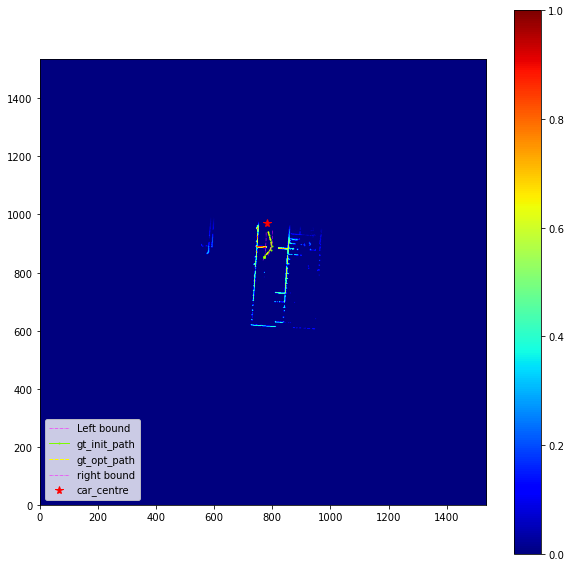

In [33]:
for features in parsed_dataset.skip(10).take(1):
    for key in features.keys():
        #if key != "grid_map":
        #print(f"{key}: {np.shape(features[key].numpy())}")
        if key=='grid_map':
            print(f"{key}: {type(features[key])}")
            #griddat = features[key].numpy()
            pass
    _ = plot_scene(features=features)
    #fig_plot.savefig("test.jpg",dpi=500)
    #plt.show()
    #plt.imshow(image,origin="lower")
    #plot_paths(ax,)
    #plt.plot(init_path[:,0],init_path[:,1],'o-', color='red')
    #plt.show()

In [ ]:
#plt.imshow(griddat)